In [1]:
# data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipeline

# model building
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# accuracy
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score

# other
import pickle
import warnings;warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('healthcare_preprocessed.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,80.0,0,1,0,0,4.662684,3.481240,1,0,0,1,0,0,0,0,1,0
1,1,74.0,1,1,0,0,4.249780,3.310543,1,0,0,1,0,0,0,0,1,0
2,0,69.0,0,0,0,0,4.547435,3.126761,1,0,0,1,0,0,0,0,1,0
3,0,59.0,0,0,0,0,4.332705,3.335770,1,0,0,1,0,0,1,0,0,0
4,0,78.0,0,0,0,0,4.070223,3.186353,1,0,0,1,0,0,1,0,0,0


#### Model with all columns

In [3]:
# feature and label
features = df.drop('stroke', axis=1)
label = df['stroke']
print(features.shape, label.shape)

(4390, 17) (4390,)


In [4]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=21)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3512, 17) (878, 17) (3512,) (878,)


In [5]:
# to balance the target class we will be using smote on training data
over = SMOTE(sampling_strategy=0.2, k_neighbors=2, random_state=21)
under = RandomUnderSampler(sampling_strategy=0.3, random_state=21)

balancer = imb_pipeline([
    ('Over', over),
    ('Under', under)
])

In [6]:
x_train_, y_train_ = balancer.fit_resample(x_train, y_train)
print(x_train_.shape, y_train_.shape)

(2933, 17) (2933,)


In [7]:
# logistic regression pipeline
lr_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', LogisticRegression())
])

# decision tree model pipeline
dt_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', DecisionTreeClassifier(random_state=91))
])

# xgb model pipeline
xgb_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', XGBClassifier(random_state=0))
])

Since we are trying to predict if a person is likely to have stroke or not, it is important for us to not miss the patient who could have this as it would be risker for him. So we will be looking for low false negative in stroke prediction. Also we will be looking for high stroke prediction precision.

Logistic Regression
(lr_model) Training set score: 0.8929423798158882
(lr_model) Test set score: 0.9054669703872438 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       837
           1       0.19      0.32      0.24        41

    accuracy                           0.91       878
   macro avg       0.58      0.63      0.59       878
weighted avg       0.93      0.91      0.92       878



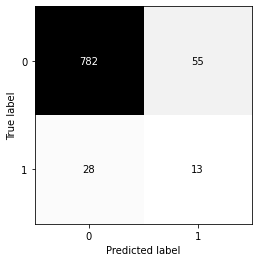

In [8]:
print("Logistic Regression")

lr_model.fit(x_train_, y_train_)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_, y_train_)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test, y_test)), '\n')

print(classification_report(y_test, lr_model.predict(x_test)))
plot_confusion_matrix(lr_model, x_test, y_test, colorbar=False, cmap='binary')

> * It's test score is impressive and doesn't seems to be overfitted
> * but its score isn't that good on predicting stroke class

Decision Tree
(dt_model) Training set score: 1.0
(dt_model) Test set score: 0.8906605922551253 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       837
           1       0.14      0.27      0.19        41

    accuracy                           0.89       878
   macro avg       0.55      0.59      0.56       878
weighted avg       0.92      0.89      0.91       878



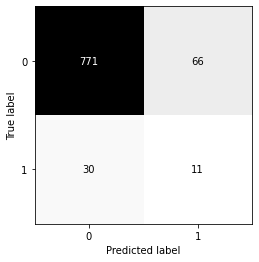

In [9]:
print("Decision Tree")

dt_model.fit(x_train_, y_train_)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_, y_train_)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test, y_test)), '\n')

print(classification_report(y_test, dt_model.predict(x_test)))
plot_confusion_matrix(dt_model, x_test, y_test, colorbar=False, cmap='binary')

> * Model is overfitted
> * stroke class precision is very less

XGBoost
[16:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(xgb_model) Training set score: 0.9993181043300375
(xgb_model) Test set score: 0.9339407744874715
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       837
           1       0.27      0.24      0.26        41

    accuracy                           0.93       878
   macro avg       0.62      0.61      0.61       878
weighted avg       0.93      0.93      0.93       878



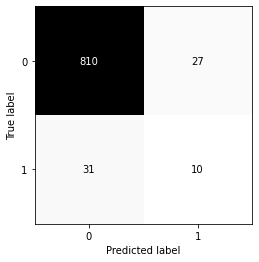

In [10]:
print("XGBoost")

xgb_model.fit(x_train_, y_train_)
print('(xgb_model) Training set score: ' + str(xgb_model.score(x_train_, y_train_)))
print('(xgb_model) Test set score: ' + str(xgb_model.score(x_test, y_test)))

print(classification_report(y_test, xgb_model.predict(x_test)))
plot_confusion_matrix(xgb_model, x_test, y_test, colorbar=False, cmap='binary')


> * It is also overfitted
> * not an impressive performance on stroke class

#### Model with best column (Information gain)

In [11]:
# these columns selected from last eda's notebook information gain
columns = ['gender', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'work_type_Govt_job',
             'work_type_Private', 'smoking_status_formerly smoked', 'smoking_status_smokes']
features_ig = features.drop(columns, axis=1)

# train test split
x_train_ig, x_test_ig, y_train_ig, y_test_ig = train_test_split(features_ig, label, test_size=0.2, random_state=21)
print(x_train_ig.shape, x_test_ig.shape, y_train_ig.shape, y_test_ig.shape)

(3512, 8) (878, 8) (3512,) (878,)


In [12]:
x_train_ig, y_train_ig = balancer.fit_resample(x_train_ig, y_train_ig)
print(x_train_ig.shape, y_train_ig.shape)

(2933, 8) (2933,)


Logistic Regression with Features selection
(lr_model) Training set score: 0.8128196385952949
(lr_model) Test set score: 0.8735763097949886 

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       837
           1       0.16      0.39      0.22        41

    accuracy                           0.87       878
   macro avg       0.56      0.64      0.58       878
weighted avg       0.93      0.87      0.90       878



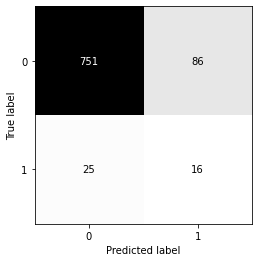

In [13]:
print("Logistic Regression with Features selection")

lr_model.fit(x_train_ig, y_train_ig)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_ig, y_train_ig)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test_ig, y_test_ig)), '\n')

print(classification_report(y_test_ig, lr_model.predict(x_test_ig)))
plot_confusion_matrix(lr_model, x_test_ig, y_test_ig, colorbar=False, cmap='binary')

> * Feature selection did improved the stroke prediction performance

Decision Tree with Features selection
(dt_model) Training set score: 0.9982952608250938
(dt_model) Test set score: 0.8895216400911162 

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       837
           1       0.20      0.44      0.27        41

    accuracy                           0.89       878
   macro avg       0.58      0.68      0.61       878
weighted avg       0.93      0.89      0.91       878



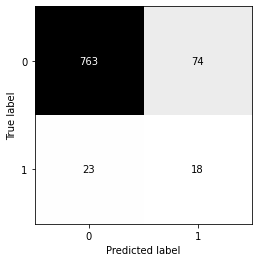

In [14]:
print("Decision Tree with Features selection")

dt_model.fit(x_train_ig, y_train_ig)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_ig, y_train_ig)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test_ig, y_test_ig)), '\n')

print(classification_report(y_test_ig, dt_model.predict(x_test_ig)))
plot_confusion_matrix(dt_model, x_test_ig, y_test_ig, colorbar=False, cmap='binary')

> * There is little improvement in stroke prediction but it is still overfitted

xgboost with Features selection
[16:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(xgb_model) Training set score: 0.9792021820661438
(xgb_model) Test set score: 0.8986332574031891 

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       837
           1       0.12      0.20      0.15        41

    accuracy                           0.90       878
   macro avg       0.54      0.56      0.55       878
weighted avg       0.92      0.90      0.91       878



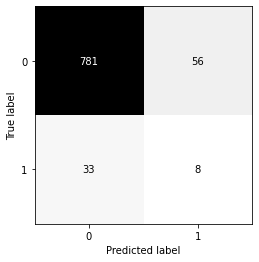

In [15]:
print("xgboost with Features selection")

xgb_model.fit(x_train_ig, y_train_ig)
print('(xgb_model) Training set score: ' + str(xgb_model.score(x_train_ig, y_train_ig)))
print('(xgb_model) Test set score: ' + str(xgb_model.score(x_test_ig, y_test_ig)), '\n')

print(classification_report(y_test_ig, xgb_model.predict(x_test_ig)))
plot_confusion_matrix(xgb_model, x_test_ig, y_test_ig, colorbar=False, cmap='binary')

> * xgboost is also overfitted

#### Model with best column (Variance Threshold)

In [16]:
# these columns selected from last eda's notebook information gain
columns = ['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'work_type_Never_worked']
features_vt = features.drop(columns, axis=1)

# train test split
x_train_vt, x_test_vt, y_train_vt, y_test_vt = train_test_split(features_vt, label, test_size=0.2, random_state=21)
print(x_train_vt.shape, x_test_vt.shape, y_train_vt.shape, y_test_vt.shape)

(3512, 12) (878, 12) (3512,) (878,)


In [17]:
x_train_vt, y_train_vt = balancer.fit_resample(x_train_vt, y_train_vt)
print(x_train_vt.shape, y_train_vt.shape)

(2933, 12) (2933,)


Logistic Regression with Features selection
(lr_model) Training set score: 0.8796454142516195
(lr_model) Test set score: 0.8940774487471527 

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       837
           1       0.19      0.39      0.26        41

    accuracy                           0.89       878
   macro avg       0.58      0.65      0.60       878
weighted avg       0.93      0.89      0.91       878



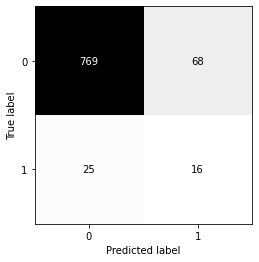

In [18]:
print("Logistic Regression with Features selection")

lr_model.fit(x_train_vt, y_train_vt)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_vt, y_train_vt)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test_vt, y_test_vt)), '\n')

print(classification_report(y_test_vt, lr_model.predict(x_test_vt)))
plot_confusion_matrix(lr_model, x_test_vt, y_test_vt, colorbar=False, cmap='binary')

> * Model has improvement from first model but isn't better than our last model

Decision Tree with Features selection
(dt_model) Training set score: 0.9652233208319128
(dt_model) Test set score: 0.9202733485193622 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       837
           1       0.15      0.15      0.15        41

    accuracy                           0.92       878
   macro avg       0.55      0.55      0.55       878
weighted avg       0.92      0.92      0.92       878



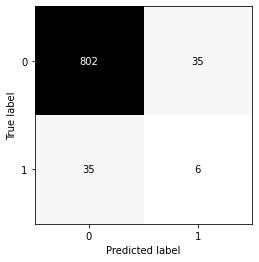

In [19]:
print("Decision Tree with Features selection")

dt_model.fit(x_train_vt, y_train_vt)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_vt, y_train_vt)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test_vt, y_test_vt)), '\n')

print(classification_report(y_test_vt, dt_model.predict(x_test_vt)))
plot_confusion_matrix(dt_model, x_test_vt, y_test_vt, colorbar=False, cmap='binary')

> * these new features doesn't helped decision tree in better stroke predicition

xgboost with Features selection
[16:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(xgb_model) Training set score: 0.9631776338220253
(xgb_model) Test set score: 0.9271070615034168 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       837
           1       0.13      0.10      0.11        41

    accuracy                           0.93       878
   macro avg       0.54      0.53      0.54       878
weighted avg       0.92      0.93      0.92       878



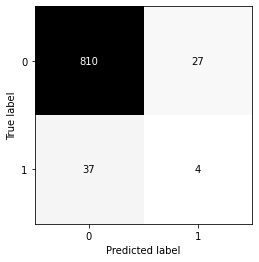

In [20]:
print("xgboost with Features selection")

xgb_model.fit(x_train_vt, y_train_vt)
print('(xgb_model) Training set score: ' + str(xgb_model.score(x_train_vt, y_train_vt)))
print('(xgb_model) Test set score: ' + str(xgb_model.score(x_test_vt, y_test_vt)), '\n')

print(classification_report(y_test_vt, xgb_model.predict(x_test_vt)))
plot_confusion_matrix(xgb_model, x_test_vt, y_test_vt, colorbar=False, cmap='binary')

#### Saving model

> * It is also not improved from new selected features

In [21]:
lr_model.fit(x_train_ig, y_train_ig)

# dumping our model 
import pickle
with open('model.pik', 'wb') as files:
    pickle.dump(lr_model, files)

#### Optimization

##### Model with Best column based on Information gain Threshold 0.005

In [22]:

# these columns selected from last eda's notebook information gain
columns = ['age', 'hypertension', 'bmi', 'work_type_Self-employed', 'work_type_children']
features_opt1 = features[columns]

# train test split
x_train_opt1, x_test_opt1, y_train_opt1, y_test_opt1 = train_test_split(features_opt1, label, test_size=0.2, random_state=21)
print(x_train_opt1.shape, x_test_opt1.shape, y_train_opt1.shape, y_test_opt1.shape)

# over and under sampling
x_train_opt1, y_train_opt1 = balancer.fit_resample(x_train_opt1, y_train_opt1)
print(x_train_opt1.shape, y_train_opt1.shape)

(3512, 5) (878, 5) (3512,) (878,)
(2933, 5) (2933,)


Logistic Regression with Features selection
(lr_model) Training set score: 0.8131605864302762
(lr_model) Test set score: 0.8792710706150342 

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       837
           1       0.21      0.56      0.30        41

    accuracy                           0.88       878
   macro avg       0.59      0.73      0.62       878
weighted avg       0.94      0.88      0.90       878



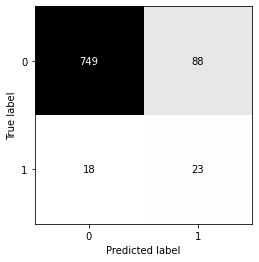

In [23]:
print("Logistic Regression with Features selection")

lr_model.fit(x_train_opt1, y_train_opt1)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_opt1, y_train_opt1)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test_opt1, y_test_opt1)), '\n')

print(classification_report(y_test_opt1, lr_model.predict(x_test_opt1)))
plot_confusion_matrix(lr_model, x_test_opt1, y_test_opt1, colorbar=False, cmap='binary')

> * After increasing threhold value of information gain and reducing some column, our recall has improved.

##### Age binning

In [24]:
def create_bins(col, cut_points, labels=None):
    minval = col.min()
    maxval = col.max()
    break_points = [minval] + cut_points+ [maxval]
    print(break_points)

    if not labels:
        labels = range(len(cut_points) +1)

    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin

In [25]:
# binning age with 4 groups
cut_points = [5, 18, 40];
labels= ["Toddlers", "Young", "Elder", "Senior"]
df["AgeGrp"] = create_bins(df["age"], cut_points, labels)
df = pd.get_dummies(df, columns=['AgeGrp'])
df.head()

[0.08, 5, 18, 40, 82.0]


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,...,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,AgeGrp_Toddlers,AgeGrp_Young,AgeGrp_Elder,AgeGrp_Senior
0,1,80.0,0,1,0,0,4.662684,3.481240,1,0,...,0,0,0,0,1,0,0,0,0,1
1,1,74.0,1,1,0,0,4.249780,3.310543,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,69.0,0,0,0,0,4.547435,3.126761,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,59.0,0,0,0,0,4.332705,3.335770,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,78.0,0,0,0,0,4.070223,3.186353,1,0,...,0,0,1,0,0,0,0,0,0,1


In [26]:
# these columns selected from last eda's notebook information gain
columns = ['AgeGrp_Elder', 'AgeGrp_Senior', 'bmi', 'ever_married', 'hypertension', 'age']
features_opt2 = df[columns]

# train test split
x_train_opt2, x_test_opt2, y_train_opt2, y_test_opt2 = train_test_split(features_opt2, label, test_size=0.2, random_state=21)
print(x_train_opt2.shape, x_test_opt2.shape, y_train_opt2.shape, y_test_opt2.shape)

# over and under sampling
x_train_opt2, y_train_opt2 = balancer.fit_resample(x_train_opt2, y_train_opt2)
print(x_train_opt2.shape, y_train_opt2.shape)

(3512, 6) (878, 6) (3512,) (878,)
(2933, 6) (2933,)


Logistic Regression with Features selection
(lr_model) Training set score: 0.8155472212751449
(lr_model) Test set score: 0.8690205011389521 

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       837
           1       0.19      0.54      0.28        41

    accuracy                           0.87       878
   macro avg       0.58      0.71      0.60       878
weighted avg       0.94      0.87      0.90       878



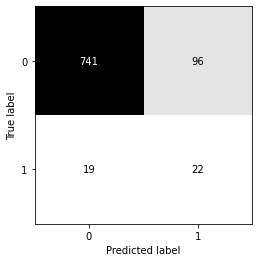

In [27]:
print("Logistic Regression with Features selection")

lr_model.fit(x_train_opt2, y_train_opt2)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_opt2, y_train_opt2)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test_opt2, y_test_opt2)), '\n')

print(classification_report(y_test_opt2, lr_model.predict(x_test_opt2)))
plot_confusion_matrix(lr_model, x_test_opt2, y_test_opt2, colorbar=False, cmap='binary')

> * Age binning did improved recall value from our previous trials but isn't the best one from our last trial.

Logistic Regression with Features selection
(dt_model) Training set score: 0.870780770542107
(dt_model) Test set score: 0.8678815489749431 

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       837
           1       0.15      0.39      0.22        41

    accuracy                           0.87       878
   macro avg       0.56      0.64      0.57       878
weighted avg       0.93      0.87      0.89       878



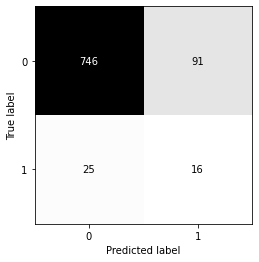

In [30]:
# decision tree model pipeline
dt_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('dt_Classifier', DecisionTreeClassifier(random_state=91, min_samples_split=12,
                                 min_samples_leaf=15))
])

print("Logistic Regression with Features selection")

dt_model.fit(x_train_opt2, y_train_opt2)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_opt2, y_train_opt2)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test_opt2, y_test_opt2)), '\n')

print(classification_report(y_test_opt2, dt_model.predict(x_test_opt2)))
plot_confusion_matrix(dt_model, x_test_opt2, y_test_opt2, colorbar=False, cmap='binary')

#### Trying other models

In [56]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# svm model pipeline
svm_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', SVC(random_state=0, kernel='linear', ))
    ])

# rfc model pipeline
rfc_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', RandomForestClassifier(random_state=0))
    ])


(svm_model) Training set score: 0.80600068189567
(svm_model) Test set score: 0.8587699316628702 

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       837
           1       0.19      0.63      0.30        41

    accuracy                           0.86       878
   macro avg       0.59      0.75      0.61       878
weighted avg       0.94      0.86      0.89       878



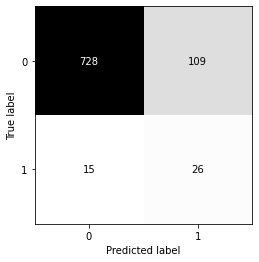

In [57]:
svm_model.fit(x_train_opt2, y_train_opt2)

print('(svm_model) Training set score: ' + str(svm_model.score(x_train_opt2, y_train_opt2)))
print('(svm_model) Test set score: ' + str(svm_model.score(x_test_opt2, y_test_opt2)), '\n')

print(classification_report(y_test_opt2, svm_model.predict(x_test_opt2)))
plot_confusion_matrix(svm_model, x_test_opt2, y_test_opt2, colorbar=False, cmap='binary')